In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline
from scipy.optimize import minimize

In [2]:
# --- 第零步：定义时间到相位的映射函数 (与之前相同) ---
def time_to_phase(t, t_start, t_end):
    """将时间t从 [t_start, t_end] 映射到相位phi [0, 1]。"""
    if t_end == t_start:
        return 0.0
    return (t - t_start) / (t_end - t_start)

def phase_to_time(phi, t_start, t_end):
    """将相位phi从 [0, 1] 映射到时间t [t_start, t_end]。"""
    return t_start + phi * (t_end - t_start)

[[ 0.          2.24835708]
 [ 0.52631579  4.16151372]
 [ 1.05263158  6.04158738]
 [ 1.57894737  7.31028297]
 [ 2.10526316  6.69412028]
 [ 2.63157895  6.47543772]
 [ 3.15789474  6.76977844]
 [ 3.68421053  5.44538816]
 [ 4.21052632  3.68974159]
 [ 4.73684211  2.92735234]
 [ 5.26315789  1.11221884]
 [ 5.78947368 -0.15734366]
 [ 6.31578947 -0.94068966]
 [ 6.84210526 -2.93681216]
 [ 7.36842105 -3.45496511]
 [ 7.89473684 -3.09234073]
 [ 8.42105263 -3.0551836 ]
 [ 8.94736842 -1.56061944]
 [ 9.47368421 -0.6846579 ]
 [10.          1.29384815]]


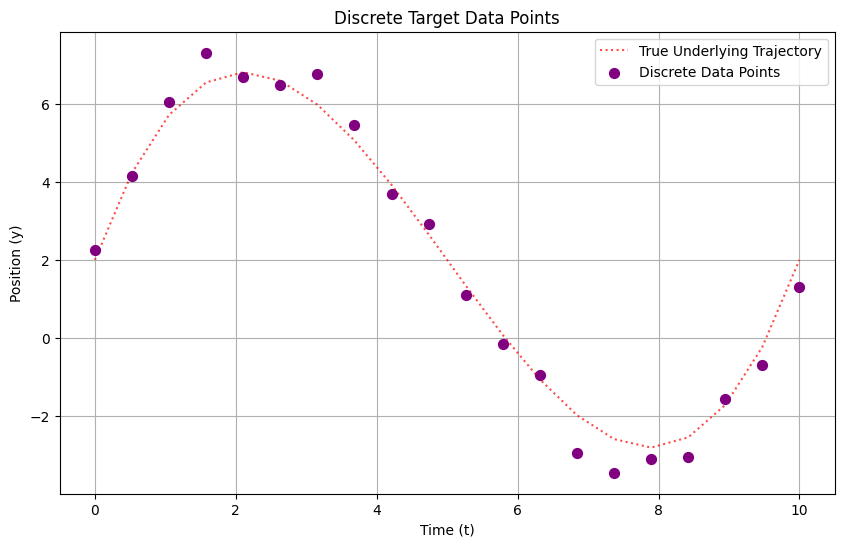

In [8]:
# --- 第一步：定义离散的目标数据点 ---
# 定义时间范围
t_start = 0
t_end = 10

# 假设我们有20个离散的数据点
num_data_points = 20
# 在时间范围内随机生成一些时间点 (或均匀分布，取决于实际数据)
# 这里我们用均匀分布，以确保覆盖整个范围
t_data = np.linspace(t_start, t_end, num_data_points)

# 生成对应的y值，这里我们仍然用一个三次函数来生成，模拟真实数据
# 但你可以用你自己的实际数据替换这部分
np.random.seed(42) # 为了结果可复现
y_data_true = 0.1 * t_data**3 - 1.5 * t_data**2 + 5 * t_data + 2
# 添加一些噪声来模拟真实数据的不完美性
y_data = y_data_true + np.random.normal(0, 0.5, num_data_points) # 添加高斯噪声

combined_data = np.column_stack((t_data, y_data))
print(combined_data)

# 可视化离散数据点
plt.figure(figsize=(10, 6))
plt.plot(t_data, y_data_true, label='True Underlying Trajectory', color='red', linestyle=':', alpha=0.7) # 真正的底层轨迹 (可选)
plt.scatter(t_data, y_data, label='Discrete Data Points', color='purple', marker='o', s=50, zorder=3)
plt.title('Discrete Target Data Points')
plt.xlabel('Time (t)')
plt.ylabel('Position (y)')
plt.grid(True)
plt.legend()
plt.show()

In [5]:
# 将数据点的时间映射到相位
phi_data = time_to_phase(t_data, t_start, t_end)

# --- 第二步：设置B样条的参数 (与之前相同，节点在 [0, 1] 范围内) ---
p = 3  # 阶数 (degree) - 三次B样条
num_control_points = 7 # 控制点数量 (n+1)

# 计算节点数量
num_knots = num_control_points + p + 1

# 生成节点向量 (Uniform knots with repeated end points)
knots = np.zeros(num_knots)
knots[:p+1] = 0.0
knots[num_knots - (p+1):] = 1.0
knots[p+1 : num_knots - (p+1)] = np.linspace(
    0.0,
    1.0,
    num_knots - 2*(p+1) + 2
)[1:-1]

print(f"B-spline degree (p): {p}")
print(f"Number of control points (n+1): {num_control_points}")
print(f"Number of knots (m+1): {num_knots}")
print(f"Knot vector (in phase [0,1]): {knots}")


B-spline degree (p): 3
Number of control points (n+1): 7
Number of knots (m+1): 11
Knot vector (in phase [0,1]): [0.   0.   0.   0.   0.25 0.5  0.75 1.   1.   1.   1.  ]


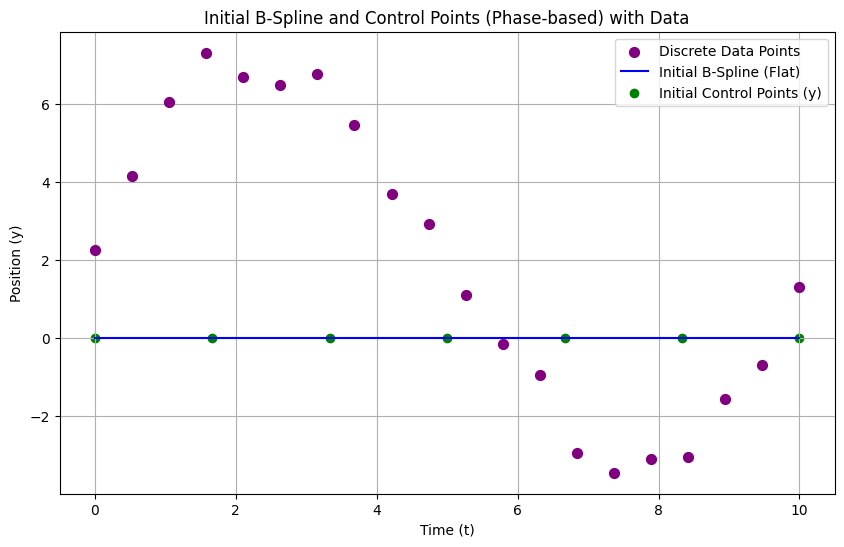

In [6]:
# 初始化控制点 (y坐标)
control_points_y_initial = np.zeros(num_control_points)

# 创建一个初始的B样条对象
initial_tck = (knots, control_points_y_initial, p)
initial_spline_y = BSpline(*initial_tck)

# 绘制初始的B样条曲线
# 注意：评估B样条时传入的是相位值 phi_values
t_plot_values = np.linspace(t_start, t_end, 100) # 用于平滑绘制曲线的时间点
phi_plot_values = time_to_phase(t_plot_values, t_start, t_end)

plt.figure(figsize=(10, 6))
plt.scatter(t_data, y_data, label='Discrete Data Points', color='purple', marker='o', s=50, zorder=3)
plt.plot(t_plot_values, initial_spline_y(phi_plot_values), label='Initial B-Spline (Flat)', color='blue')
control_points_phi_x = np.linspace(0.0, 1.0, num_control_points)
control_points_t_x = phase_to_time(control_points_phi_x, t_start, t_end)
plt.scatter(control_points_t_x, control_points_y_initial, color='green', marker='o', label='Initial Control Points (y)')
plt.title('Initial B-Spline and Control Points (Phase-based) with Data')
plt.xlabel('Time (t)')
plt.ylabel('Position (y)')
plt.grid(True)
plt.legend()
plt.show()

In [10]:
# --- 第三步：通过优化拟合离散数据点 ---

# 定义损失函数 (均方误差)
def loss_function(control_points_y, t_data, y_data, knots, p, t_start, t_end):
    """
    计算给定控制点下B样条曲线与离散数据点之间的均方误差。
    """
    spline = BSpline(knots, control_points_y, p)
    
    # 评估B样条在每个数据点时间对应的相位处的值
    phi_data_points = time_to_phase(t_data, t_start, t_end)
    spline_y_at_data = spline(phi_data_points)
    
    # 均方误差
    mse = np.mean((spline_y_at_data - y_data)**2)
    return mse

# 运行优化器
result = minimize(
    loss_function,
    control_points_y_initial, # 初始猜测值
    args=(t_data, y_data, knots, p, t_start, t_end), # 传递给损失函数的额外参数
    method='L-BFGS-B', # 推荐使用边界约束或无约束方法
    options={'disp': True, 'maxiter': 1000}
)

# 得到最优的控制点
optimal_control_points_y = result.x
print(f"\nOptimal control points (y): {optimal_control_points_y}")
print(f"Final loss (MSE): {result.fun}")

# 使用最优控制点创建最终的B样条
optimal_tck = (knots, optimal_control_points_y, p)
optimal_spline_y = BSpline(*optimal_tck)


Optimal control points (y): [ 2.13466073  6.51001355  8.41831878  2.38333166 -5.61685459 -1.7282715
  1.24482754]
Final loss (MSE): 0.09656400032338248


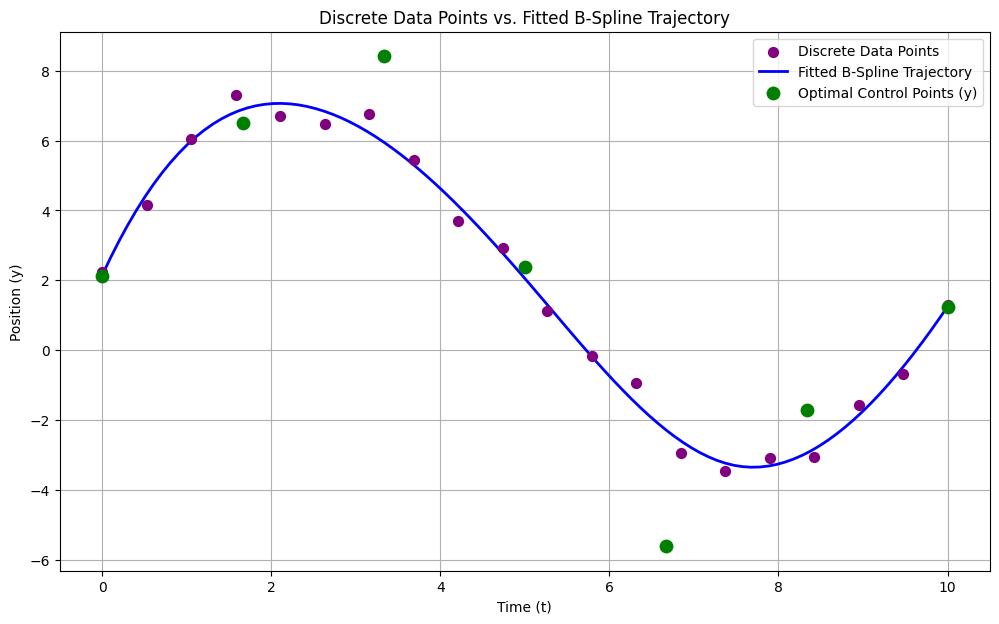

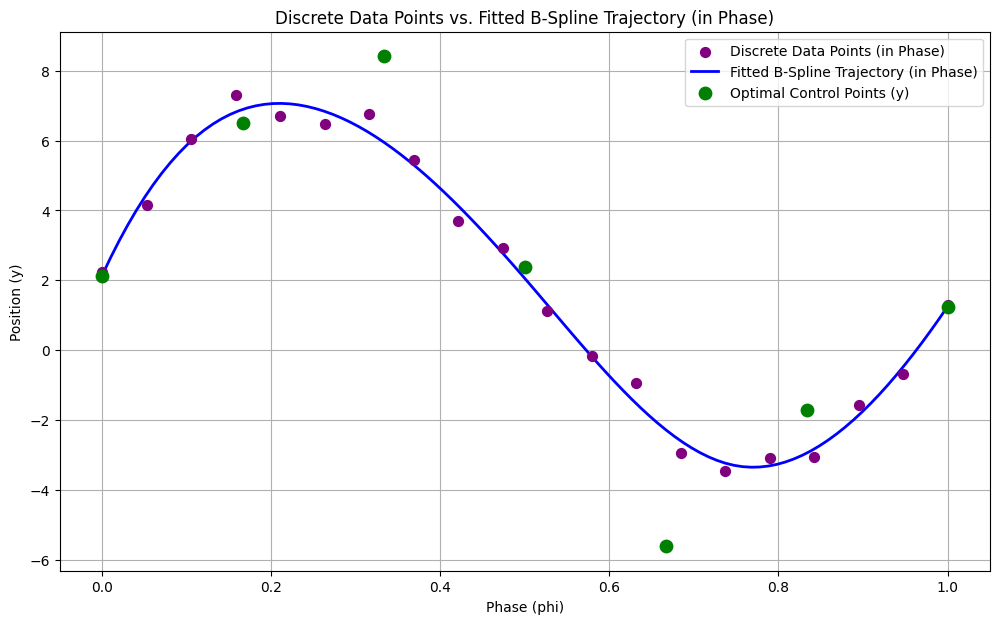

In [11]:
# --- 第四步：可视化拟合结果 ---
plt.figure(figsize=(12, 7))
plt.scatter(t_data, y_data, label='Discrete Data Points', color='purple', marker='o', s=50, zorder=3)
# 绘制拟合后的B样条曲线，使用更密集的采样点以确保曲线平滑
plt.plot(t_plot_values, optimal_spline_y(phi_plot_values), label='Fitted B-Spline Trajectory', color='blue', linewidth=2)

# 绘制最优控制点
plt.scatter(control_points_t_x, optimal_control_points_y, color='green', marker='o', s=80, zorder=5, label='Optimal Control Points (y)')

plt.title('Discrete Data Points vs. Fitted B-Spline Trajectory')
plt.xlabel('Time (t)')
plt.ylabel('Position (y)')
plt.grid(True)
plt.legend()
plt.show()

# 额外可视化：在相位空间中查看B样条和控制点
plt.figure(figsize=(12, 7))
plt.scatter(phi_data, y_data, label='Discrete Data Points (in Phase)', color='purple', marker='o', s=50, zorder=3)
plt.plot(phi_plot_values, optimal_spline_y(phi_plot_values), label='Fitted B-Spline Trajectory (in Phase)', color='blue', linewidth=2)
plt.scatter(control_points_phi_x, optimal_control_points_y, color='green', marker='o', s=80, zorder=5, label='Optimal Control Points (y)')

plt.title('Discrete Data Points vs. Fitted B-Spline Trajectory (in Phase)')
plt.xlabel('Phase (phi)')
plt.ylabel('Position (y)')
plt.grid(True)
plt.legend()
plt.show()